<a href="https://colab.research.google.com/github/ChirathD/Tuberculosis/blob/master/unet_lungsegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
!pip install kaggle

In [64]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chirathd","key":"1cae6df439b65a39bcf2a8f85979946e"}'}

In [0]:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [66]:
!kaggle datasets download -d kmader/pulmonary-chest-xray-abnormalities

100% 4.08G/4.09G [00:33<00:00, 170MB/s]
100% 4.09G/4.09G [00:33<00:00, 129MB/s]


In [67]:
!kaggle datasets download -d yoctoman/shcxr-lung-mask

 51% 5.00M/9.77M [00:00<00:00, 43.9MB/s]
100% 9.77M/9.77M [00:00<00:00, 58.3MB/s]


In [68]:
!mkdir ..//content/segmentation
!mkdir ..//content/segmentation/test
!mkdir ..//content/segmentation/train
!mkdir ..//content/segmentation/train/augmentation
!mkdir ..//content/segmentation/train/image
!mkdir ..//content/segmentation/train/mask
!mkdir ..//content/segmentation/train/dilate

mkdir: cannot create directory ‘..//content/segmentation’: File exists
mkdir: cannot create directory ‘..//content/segmentation/test’: File exists
mkdir: cannot create directory ‘..//content/segmentation/train’: File exists
mkdir: cannot create directory ‘..//content/segmentation/train/augmentation’: File exists
mkdir: cannot create directory ‘..//content/segmentation/train/image’: File exists
mkdir: cannot create directory ‘..//content/segmentation/train/mask’: File exists
mkdir: cannot create directory ‘..//content/segmentation/train/dilate’: File exists


In [0]:
import os

import numpy as np
import cv2
import matplotlib.pyplot as plt

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

from glob import glob
from tqdm import tqdm

In [0]:
INPUT_DIR = os.path.join("..", "content")

SEGMENTATION_DIR = os.path.join(INPUT_DIR, "segmentation")
SEGMENTATION_TEST_DIR = os.path.join(SEGMENTATION_DIR, "test")
SEGMENTATION_TRAIN_DIR = os.path.join(SEGMENTATION_DIR, "train")
SEGMENTATION_AUG_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "augmentation")
SEGMENTATION_IMAGE_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "image")
SEGMENTATION_MASK_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "mask")
SEGMENTATION_DILATE_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "dilate")


In [0]:
!unzip -q -o pulmonary-chest-xray-abnormalities.zip -d pulmonary

In [0]:
!unzip -q -o shcxr-lung-mask.zip -d shcxr

In [73]:
%cd ./pulmonary
%pwd
!ls

/content/pulmonary
ChinaSet_AllFiles  ChinaSet_AllFiles.zip  Montgomery  Montgomery.zip


In [0]:
!unzip -q -o Montgomery.zip -d Montgomery

In [0]:
!unzip -q -o ChinaSet_AllFiles.zip -d ChinaSet_AllFiles


In [0]:
!rm Montgomery.zip
!rm ChinaSet_AllFiles.zip

In [77]:
%cd -

/content


In [78]:
%cd ./shcxr
%pwd
!ls

/content/shcxr
mask  mask.zip


In [0]:
!unzip -q -o mask.zip -d mask

In [80]:
%cd -

/content


In [0]:
!rm pulmonary-chest-xray-abnormalities.zip
!rm shcxr-lung-mask.zip

In [82]:
%pwd
!ls

dice_coeff.png	Loss.png   sample_data	segmentation  test.png
loss.png	pulmonary  save_image	shcxr


In [0]:
SEGMENTATION_SOURCE_DIR = os.path.join(INPUT_DIR, \
                                       "pulmonary")

SHENZHEN_TRAIN_DIR = os.path.join(SEGMENTATION_SOURCE_DIR,"ChinaSet_AllFiles", \
                                  "ChinaSet_AllFiles")
SHENZHEN_IMAGE_DIR = os.path.join(SHENZHEN_TRAIN_DIR, "CXR_png")
SHENZHEN_MASK_DIR = os.path.join(INPUT_DIR, "shcxr", "mask", "mask")

MONTGOMERY_TRAIN_DIR = os.path.join(SEGMENTATION_SOURCE_DIR, \
                                    "Montgomery", "MontgomerySet")
MONTGOMERY_IMAGE_DIR = os.path.join(MONTGOMERY_TRAIN_DIR, "CXR_png")
MONTGOMERY_LEFT_MASK_DIR = os.path.join(MONTGOMERY_TRAIN_DIR, \
                                        "ManualMask", "leftMask")
MONTGOMERY_RIGHT_MASK_DIR = os.path.join(MONTGOMERY_TRAIN_DIR, \
                                         "ManualMask", "rightMask")

DILATE_KERNEL = np.ones((15, 15), np.uint8)

BATCH_SIZE=2

#Prod
EPOCHS=60

#Desv
#EPOCHS=16

In [84]:
montgomery_left_mask_dir = glob(os.path.join(MONTGOMERY_LEFT_MASK_DIR, '*.png'))
montgomery_test = montgomery_left_mask_dir[0:50]
montgomery_train= montgomery_left_mask_dir[50:]

for left_image_file in tqdm(montgomery_left_mask_dir):
    base_file = os.path.basename(left_image_file)
    image_file = os.path.join(MONTGOMERY_IMAGE_DIR, base_file)
    right_image_file = os.path.join(MONTGOMERY_RIGHT_MASK_DIR, base_file)

    image = cv2.imread(image_file)
    left_mask = cv2.imread(left_image_file, cv2.IMREAD_GRAYSCALE)
    right_mask = cv2.imread(right_image_file, cv2.IMREAD_GRAYSCALE)
    
    image = cv2.resize(image, (512, 512))
    left_mask = cv2.resize(left_mask, (512, 512))
    right_mask = cv2.resize(right_mask, (512, 512))
    
    mask = np.maximum(left_mask, right_mask)
    mask_dilate = cv2.dilate(mask, DILATE_KERNEL, iterations=1)
    
    if (left_image_file in montgomery_train):
        cv2.imwrite(os.path.join(SEGMENTATION_IMAGE_DIR, base_file), \
                    image)
        cv2.imwrite(os.path.join(SEGMENTATION_MASK_DIR, base_file), \
                    mask)
        cv2.imwrite(os.path.join(SEGMENTATION_DILATE_DIR, base_file), \
                    mask_dilate)
    else:
        filename, fileext = os.path.splitext(base_file)
        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, base_file), \
                    image)
        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_mask%s" % (filename, fileext)), mask)
        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_dilate%s" % (filename, fileext)), mask_dilate)

100%|██████████| 138/138 [00:48<00:00,  2.97it/s]


In [0]:
def add_colored_dilate(image, mask_image, dilate_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    dilate_image_gray = cv2.cvtColor(dilate_image, cv2.COLOR_BGR2GRAY)
    
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    dilate = cv2.bitwise_and(dilate_image, dilate_image, mask=dilate_image_gray)
    
    mask_coord = np.where(mask!=[0,0,0])
    dilate_coord = np.where(dilate!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[100,0,255]
    dilate[dilate_coord[0],dilate_coord[1],:] = [0,255,0]

    ret = cv2.addWeighted(image, 0.7, dilate, 0.2, 0)
    ret = cv2.addWeighted(ret, 0.7, mask, 0.2, 0)

    return ret

def add_colored_mask(image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    
    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[0,0,255]

    ret = cv2.addWeighted(image, 0.7, mask, 0.2, 0)

    return ret

def diff_mask(ref_image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    
    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]

    ret = cv2.addWeighted(ref_image, 0.7, mask, 0.3, 0)
    return ret

In [0]:
def add_colored_dilate(image, mask_image, dilate_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    dilate_image_gray = cv2.cvtColor(dilate_image, cv2.COLOR_BGR2GRAY)
    
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    dilate = cv2.bitwise_and(dilate_image, dilate_image, mask=dilate_image_gray)
    
    mask_coord = np.where(mask!=[0,0,0])
    dilate_coord = np.where(dilate!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]
    dilate[dilate_coord[0],dilate_coord[1],:] = [0,0,255]

    ret = cv2.addWeighted(image, 0.7, dilate, 0.3, 0)
    ret = cv2.addWeighted(ret, 0.7, mask, 0.3, 0)

    return ret

def add_colored_mask(image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    
    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]

    ret = cv2.addWeighted(image, 0.7, mask, 0.3, 0)

    return ret

def diff_mask(ref_image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    
    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]

    ret = cv2.addWeighted(ref_image, 0.7, mask, 0.3, 0)
    return ret

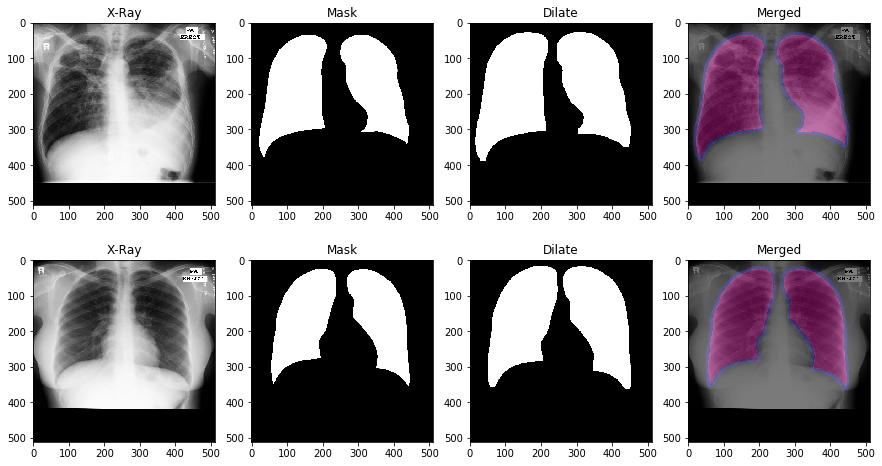

In [87]:
base_file = os.path.basename(montgomery_train[0])

image_file = os.path.join(SEGMENTATION_IMAGE_DIR, base_file)
mask_image_file = os.path.join(SEGMENTATION_MASK_DIR, base_file)
dilate_image_file = os.path.join(SEGMENTATION_DILATE_DIR, base_file)

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)
                          
fig, axs = plt.subplots(2, 4, figsize=(15, 8))

axs[0, 0].set_title("X-Ray")
axs[0, 0].imshow(image)

axs[0, 1].set_title("Mask")
axs[0, 1].imshow(mask_image)

axs[0, 2].set_title("Dilate")
axs[0, 2].imshow(dilate_image)

axs[0, 3].set_title("Merged")
axs[0, 3].imshow(merged_image)

base_file = os.path.basename(montgomery_test[0])
filename, fileext = os.path.splitext(base_file)
image_file = os.path.join(SEGMENTATION_TEST_DIR, base_file)
mask_image_file = os.path.join(SEGMENTATION_TEST_DIR, \
                               "%s_mask%s" % (filename, fileext))
dilate_image_file = os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_dilate%s" % (filename, fileext))

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)

axs[1, 0].set_title("X-Ray")
axs[1, 0].imshow(image)

axs[1, 1].set_title("Mask")
axs[1, 1].imshow(mask_image)

axs[1, 2].set_title("Dilate")
axs[1, 2].imshow(dilate_image)

axs[1, 3].set_title("Merged")
axs[1, 3].imshow(merged_image)

In [88]:
shenzhen_mask_dir = glob(os.path.join(SHENZHEN_MASK_DIR, '*.png'))
shenzhen_test = shenzhen_mask_dir[0:50]
shenzhen_train= shenzhen_mask_dir[50:]

for mask_file in tqdm(shenzhen_mask_dir):
    base_file = os.path.basename(mask_file).replace("_mask", "")
    image_file = os.path.join(SHENZHEN_IMAGE_DIR, base_file)

    image = cv2.imread(image_file)
    mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
        
    image = cv2.resize(image, (512, 512))
    mask = cv2.resize(mask, (512, 512))
    mask_dilate = cv2.dilate(mask, DILATE_KERNEL, iterations=1)
    
    if (mask_file in shenzhen_train):
        cv2.imwrite(os.path.join(SEGMENTATION_IMAGE_DIR, base_file), \
                    image)
        cv2.imwrite(os.path.join(SEGMENTATION_MASK_DIR, base_file), \
                    mask)
        cv2.imwrite(os.path.join(SEGMENTATION_DILATE_DIR, base_file), \
                    mask_dilate)
    else:
        filename, fileext = os.path.splitext(base_file)

        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, base_file), \
                    image)
        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_mask%s" % (filename, fileext)), mask)
        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_dilate%s" % (filename, fileext)), mask_dilate)

100%|██████████| 566/566 [01:39<00:00,  5.39it/s]


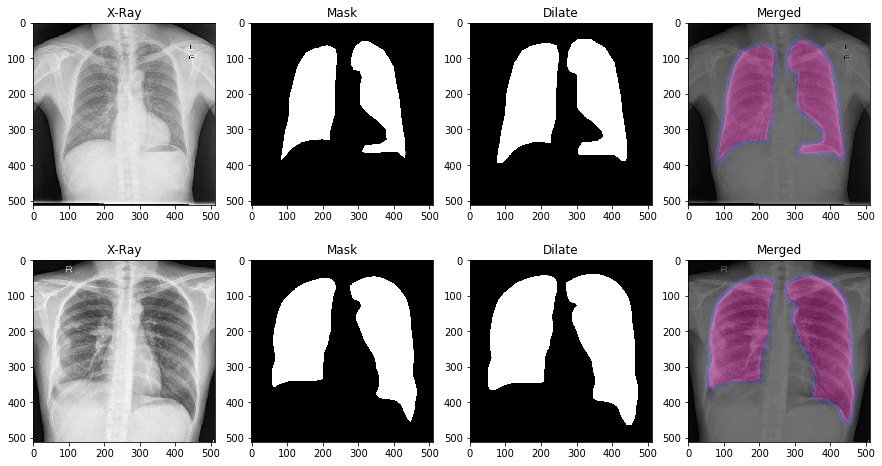

In [89]:
base_file = os.path.basename(shenzhen_train[0].replace("_mask", ""))

image_file = os.path.join(SEGMENTATION_IMAGE_DIR, base_file)
mask_image_file = os.path.join(SEGMENTATION_MASK_DIR, base_file)
dilate_image_file = os.path.join(SEGMENTATION_DILATE_DIR, base_file)

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)
                          
fig, axs = plt.subplots(2, 4, figsize=(15, 8))

axs[0, 0].set_title("X-Ray")
axs[0, 0].imshow(image)

axs[0, 1].set_title("Mask")
axs[0, 1].imshow(mask_image)

axs[0, 2].set_title("Dilate")
axs[0, 2].imshow(dilate_image)

axs[0, 3].set_title("Merged")
axs[0, 3].imshow(merged_image)

base_file = os.path.basename(shenzhen_test[0].replace("_mask", ""))
image_file = os.path.join(SEGMENTATION_TEST_DIR, base_file)
filename, fileext = os.path.splitext(base_file)
mask_image_file = os.path.join(SEGMENTATION_TEST_DIR, \
                               "%s_mask%s" % (filename, fileext))

filename, fileext = os.path.splitext(base_file)
image_file = os.path.join(SEGMENTATION_TEST_DIR, base_file)
mask_image_file = os.path.join(SEGMENTATION_TEST_DIR, \
                               "%s_mask%s" % (filename, fileext))
dilate_image_file = os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_dilate%s" % (filename, fileext))

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)

axs[1, 0].set_title("X-Ray")
axs[1, 0].imshow(image)

axs[1, 1].set_title("Mask")
axs[1, 1].imshow(mask_image)

axs[1, 2].set_title("Dilate")
axs[1, 2].imshow(dilate_image)

axs[1, 3].set_title("Merged")
axs[1, 3].imshow(merged_image)

In [90]:
train_files = glob(os.path.join(SEGMENTATION_IMAGE_DIR, "*.png"))
test_files = glob(os.path.join(SEGMENTATION_TEST_DIR, "*.png"))
mask_files = glob(os.path.join(SEGMENTATION_MASK_DIR, "*.png"))
dilate_files = glob(os.path.join(SEGMENTATION_DILATE_DIR, "*.png"))

(len(train_files), \
 len(test_files), \
 len(mask_files), \
 len(dilate_files))

(604, 400, 604, 604)

In [91]:
!mkdir ..//content/save_image

mkdir: cannot create directory ‘..//content/save_image’: File exists


In [0]:
SAVE_DIR = os.path.join(INPUT_DIR, "save_image")

In [0]:
def train_generator(batch_size, train_path, image_folder, mask_folder, aug_dict,
        image_color_mode="grayscale",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=SAVE_DIR,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [0]:
def test_load_image(test_file, target_size=(256,256)):
    img = cv2.imread(test_file, cv2.IMREAD_GRAYSCALE)
    img = img / 255
    img = cv2.resize(img, target_size)
    img = np.reshape(img, img.shape + (1,))
    img = np.reshape(img,(1,) + img.shape)
    return img

def test_generator(test_files, target_size=(256,256)):
    for test_file in test_files:
        yield test_load_image(test_file, target_size)
        
def save_result(save_path, npyfile, test_files):
    for i, item in enumerate(npyfile):
        result_file = test_files[i]
        img = (item[:, :, 0] * 255.).astype(np.uint8)

        filename, fileext = os.path.splitext(os.path.basename(result_file))

        result_file = os.path.join(save_path, "%s_predict%s" % (filename, fileext))

        cv2.imwrite(result_file, img)

In [95]:
def add_suffix(base_file, suffix):
    filename, fileext = os.path.splitext(base_file)
    return "%s_%s%s" % (filename, suffix, fileext)

test_files = [test_file for test_file in glob(os.path.join(SEGMENTATION_TEST_DIR, "*.png")) \
              if ("_mask" not in test_file \
                  and "_dilate" not in test_file \
                  and "_predict" not in test_file)]

validation_data = (test_load_image(test_files[0], target_size=(512, 512)),
                    test_load_image(add_suffix(test_files[0], "dilate"), target_size=(512, 512)))

len(test_files), len(validation_data)

(100, 2)

In [0]:
EPOCHS=50

In [36]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(BATCH_SIZE,
                            SEGMENTATION_TRAIN_DIR,
                            'image',
                            'dilate', 
                            train_generator_args,
                            target_size=(512,512),
                            save_to_dir=os.path.abspath(SEGMENTATION_AUG_DIR))

model = unet(input_size=(512,512,1))
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, \
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()

model_checkpoint = ModelCheckpoint('unet_lung_seg.hdf5', 
                                    monitor='val_acc', 
                                   verbose=1, 
                                   save_best_only=True)

history = model.fit_generator(train_gen,
                              steps_per_epoch=len(train_files) / BATCH_SIZE, 
                              epochs=EPOCHS, 
                              callbacks=[model_checkpoint],
                              validation_data = validation_data)

W0614 05:51:01.016895 140526101079936 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0614 05:51:01.070714 140526101079936 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0614 05:51:01.097865 140526101079936 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0614 05:51:01.156179 140526101079936 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0614 05:51:01.570617 140526101079936 deprecation_wrapp

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 256, 32) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

W0614 05:51:01.950298 140526101079936 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0614 05:51:02.697974 140526101079936 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/150
Found 604 images belonging to 1 classes.
Found 604 images belonging to 1 classes.
302/302 [==============================] - 123s 408ms/step - loss: -0.4366 - dice_coef: 0.4366 - binary_accuracy: 0.3098 - val_loss: -0.5405 - val_dice_coef: 0.5405 - val_binary_accuracy: 0.3449
Epoch 2/150


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:434: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


302/302 [==============================] - 109s 359ms/step - loss: -0.6106 - dice_coef: 0.6106 - binary_accuracy: 0.6419 - val_loss: -0.7099 - val_dice_coef: 0.7099 - val_binary_accuracy: 0.7624
Epoch 3/150
302/302 [==============================] - 109s 360ms/step - loss: -0.6687 - dice_coef: 0.6687 - binary_accuracy: 0.7300 - val_loss: -0.7403 - val_dice_coef: 0.7403 - val_binary_accuracy: 0.8028
Epoch 4/150
302/302 [==============================] - 109s 359ms/step - loss: -0.6882 - dice_coef: 0.6882 - binary_accuracy: 0.7555 - val_loss: -0.7427 - val_dice_coef: 0.7427 - val_binary_accuracy: 0.8108
Epoch 5/150
302/302 [==============================] - 109s 360ms/step - loss: -0.7365 - dice_coef: 0.7365 - binary_accuracy: 0.8151 - val_loss: -0.7365 - val_dice_coef: 0.7365 - val_binary_accuracy: 0.8112
Epoch 6/150
302/302 [==============================] - 109s 360ms/step - loss: -0.8204 - dice_coef: 0.8204 - binary_accuracy: 0.8829 - val_loss: -0.8568 - val_dice_coef: 0.8568 - val_b

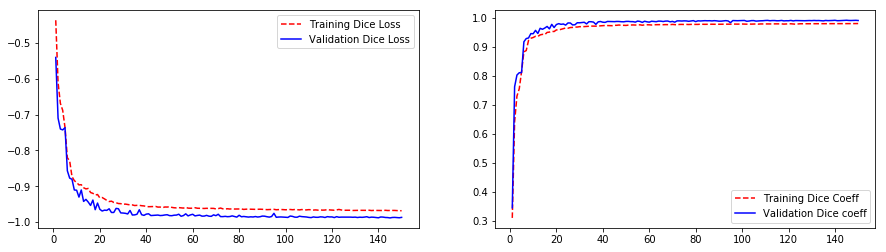

In [51]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

training_accuracy = history.history['binary_accuracy']
validation_accuracy = history.history['val_binary_accuracy']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_loss, 'r--')
axs[0].plot(epoch_count, validation_loss, 'b-')
axs[0].legend(['Training Dice Loss', 'Validation Dice Loss'])

axs[1].plot(epoch_count, training_accuracy, 'r--')
axs[1].plot(epoch_count, validation_accuracy, 'b-')
axs[1].legend(['Training Dice Coeff', 'Validation Dice coeff'])

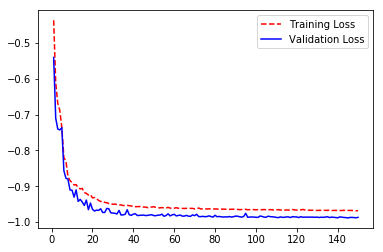

In [52]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

training_accuracy = history.history['binary_accuracy']
validation_accuracy = history.history['val_binary_accuracy']

epoch_count = range(1, len(training_loss) + 1)

fig = plt.figure()
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, validation_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()



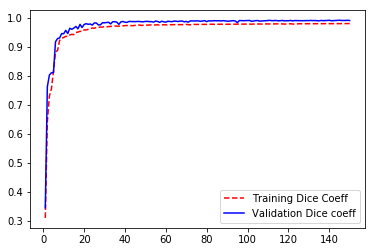

In [159]:
fig = plt.figure()
plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, validation_accuracy, 'b-')
plt.legend(['Training Dice Coeff', 'Validation Dice coeff'])

In [0]:
fig.savefig( "Loss.png")
files.download("Loss.png")

In [54]:
test_gen = test_generator(test_files, target_size=(512,512))
results = model.predict_generator(test_gen, len(test_files), verbose=1)
save_result(SEGMENTATION_TEST_DIR, results, test_files)

100/100 [==============================] - 7s 68ms/step


In [55]:
test_gen = test_generator(test_files, target_size=(512,512))
results = model.predict_generator(test_gen, len(test_files), verbose=1)
save_result(SAVE_DIR, results, test_files)

100/100 [==============================] - 7s 66ms/step


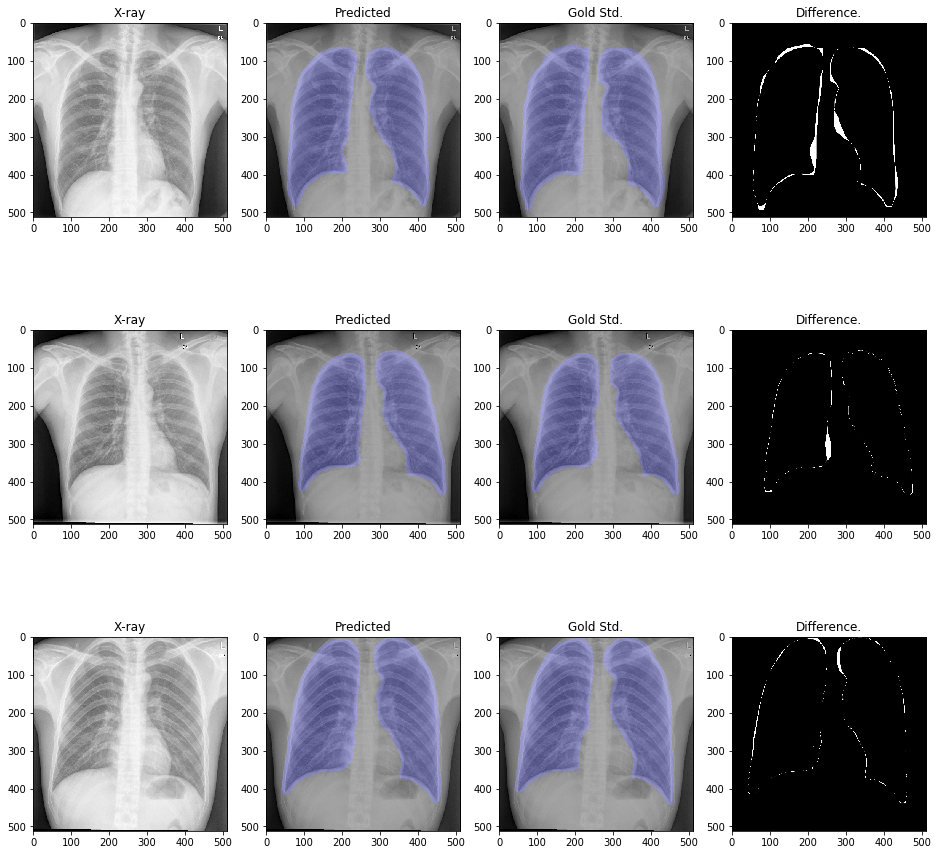

In [145]:
fig, axs = plt.subplots(3, 4, figsize=(16, 16))

image = cv2.imread("../content/segmentation/test/CHNCXR_0421_1.png")
predict_image = cv2.imread("../content/segmentation/test/CHNCXR_0421_1_predict.png")
mask_image = cv2.imread("../content/segmentation/test/CHNCXR_0421_1_dilate.png")

axs[0, 0].set_title("X-ray")
axs[0, 0].imshow(image)
axs[0, 1].set_title("Predicted")
axs[0, 1].imshow(add_colored_mask(image, predict_image))
axs[0, 2].set_title("Gold Std.")
axs[0, 2].imshow(add_colored_mask(image, mask_image))
axs[0, 3].set_title("Difference.")
axs[0, 3].imshow(mask_image-predict_image)

image = cv2.imread("../content/segmentation/test/CHNCXR_0116_0.png")
predict_image = cv2.imread("../content/segmentation/test/CHNCXR_0116_0_predict.png")
mask_image = cv2.imread("../content/segmentation/test/CHNCXR_0116_0_dilate.png")

axs[1, 0].set_title("X-ray")
axs[1, 0].imshow(image)
axs[1, 1].set_title("Predicted")
axs[1, 1].imshow(add_colored_mask(image, predict_image))
axs[1, 2].set_title("Gold Std.")
axs[1, 2].imshow(add_colored_mask(image, mask_image))
axs[1, 3].set_title("Difference.")
axs[1, 3].imshow(mask_image-predict_image)

image = cv2.imread("../content/segmentation/test/CHNCXR_0177_0.png")
predict_image = cv2.imread("../content/segmentation/test/CHNCXR_0177_0_predict.png")
mask_image = cv2.imread("../content/segmentation/test/CHNCXR_0177_0_dilate.png")

axs[2, 0].set_title("X-ray")
axs[2, 0].imshow(image)
axs[2, 1].set_title("Predicted")
axs[2, 1].imshow(add_colored_mask(image, predict_image))
axs[2, 2].set_title("Gold Std.")
axs[2, 2].imshow(add_colored_mask(image, mask_image))
axs[2, 3].set_title("Difference.")
axs[2, 3].imshow((mask_image-predict_image))


In [0]:
image = cv2.imread("../content/segmentation/test/CHNCXR_0177_0.png")
predict_image = cv2.imread("../content/segmentation/test/CHNCXR_0177_0_predict.png")
mask_image = cv2.imread("../content/segmentation/test/CHNCXR_0177_0_dilate.png")

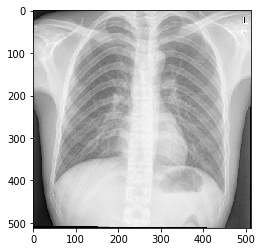

In [172]:
fig = plt.figure()
#fig.suptitle("X-ray")
plt.imshow(image)
fig.savefig( "xray_3.png")
files.download("xray_3.png")


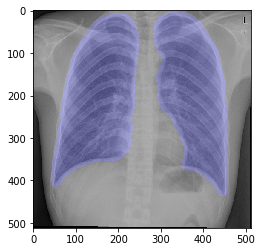

In [173]:
fig = plt.figure()
#fig.suptitle("Predicted ")
plt.imshow(add_colored_mask(image, predict_image))
fig.savefig( "predict_3.png")
files.download("predict_3.png")

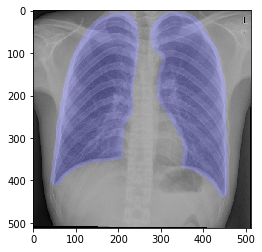

In [174]:
fig = plt.figure()
#fig.suptitle("Gold Standard.")
plt.imshow(add_colored_mask(image, mask_image))
fig.savefig( "gold_3.png")
files.download("gold_3.png")

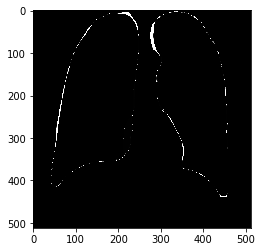

In [175]:
fig = plt.figure()
#fig.suptitle("Difference Map.")
plt.imshow(mask_image-predict_image)
fig.savefig( "diff_3.png")
files.download("diff_3.png")

In [0]:
image_path='../content/pulmonary/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/CHNCXR_0199_0.png'

In [0]:
image = cv2.imread('../content/pulmonary/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/CHNCXR_0199_0.png')

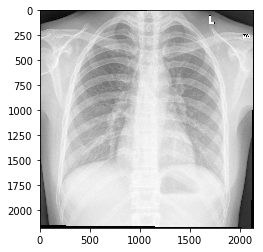

In [232]:
fig = plt.figure()
plt.imshow(image)
fig.savefig( "original_nocontrast.png")
files.download("original_nocontrast.png")

-1

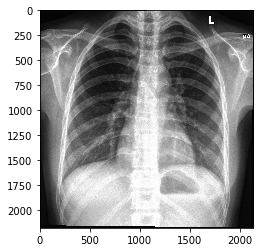

In [233]:
fig = plt.figure()
img = cv2.imread(image_path)

img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

# equalize the histogram of the Y channel
img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])

# convert the YUV image back to RGB format
img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

plt.imshow(img)
plt.imshow(img_output)

cv2.waitKey(0)

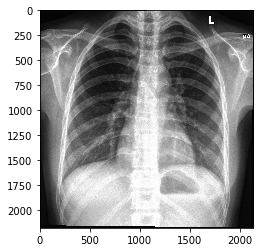

In [234]:
plt.imshow(img_output)
fig.savefig( "CLEHE.png")
files.download("CLEHE.png")

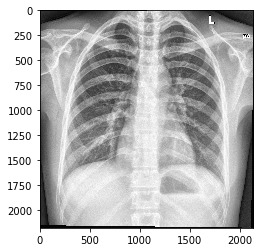

In [235]:
fig = plt.figure()
bgr = cv2.imread(image_path)

lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)

lab_planes = cv2.split(lab)

clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(8,8))

lab_planes[0] = clahe.apply(lab_planes[0])

lab = cv2.merge(lab_planes)

bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
plt.imshow(bgr)
fig.savefig( "HIST.png")
files.download("HIST.png")

In [0]:
image=equalize_clahe_image("../content/segmentation/test/CHNCXR_0177_0.png")

In [0]:
fig, axs = plt.subplots(1, 3, figsize=(16, 16))
axs[0, 0].set_title("X-ray")
axs[0, 0].imshow(image)
axs[0, 1].set_title("Histogram Equalization")
axs[0, 1].imshow(img_output)
axs[0, 2].set_title("CLAHE")
axs[0, 2].imshow(bgr)


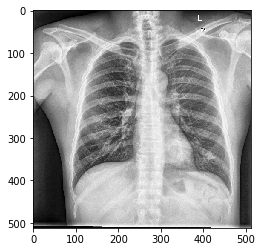

In [199]:
plt.imshow(bgr)